In [1]:
from scipy.stats import qmc
import pandas as pd
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import shutil
import os
import numpy as np
from scipy.integrate import simps
from sklearn.metrics import mean_squared_error
from math import sqrt
import subprocess
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import ListedColormap
import contextily as ctx
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")

In [2]:
#reading in data with relative paths so that it can be used by others who clone repository from github
script_dir = os.getcwd()

# the baseline were useing for treeplanting scenatio is all grass and its been extended 5km 
base_source_folder = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_inputs', 'sensitivity_analysis', 'july_allgrassextended_narrow20'))

#Temperature Observations folder
observed_temp_path = os.path.abspath(os.path.join(script_dir, 'observations', 'TemperatureDataObs'))
#Temperature observations
obs = pd.read_csv(os.path.join(observed_temp_path, 'HourlySummer23Master_riverkm.csv'))

#reading in a model run without topographic shading, for use in determining whether a reach is forested or not
notopo_source_folder = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_inputs', 'notopo_models', 'July_notopo_extended'))

#lc data scenario with buffer, to be used for adding forest to previously foresgrassyted areas
buffer_source_folder = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_inputs', 'vegetation_buffers', 'july_allforest_extended'))


In [3]:
#getting date times for modeled outputs
control_file = pd.read_csv(os.path.join(base_source_folder, 'HeatSource_Control.csv'))
cc_start = control_file.loc[7]['VALUE']
cc_start = pd.to_datetime(cc_start)
cc_end = control_file.loc[8]['VALUE']
cc_end = pd.to_datetime(cc_end)

#reading observed hourly temps for model range (for joining datetimes)
#obs = pd.read_csv(r"D:\Ben_wd\THESIS\streamtemperature\WFK23\Summer23\mainstemhourly_km.csv")
obs["datetime"] = pd.to_datetime(obs["datetime"])
#obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'07-02-2023')]# + pd.DateOffset(1))]
obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end + pd.DateOffset(1))]

# Make observed temps compatible with heatsource outputs
obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
#obs_clip.drop(19.2, axis=1, inplace=True)
obs_clip_mean = obs_clip.resample('D').mean()

In [4]:
notopo_shade_df = pd.read_csv(os.path.join(notopo_source_folder, 'outputs\Shade.csv'), skiprows=6,
         usecols=range(1, 187))
notopo_shade_df.columns = [float(col) for col in notopo_shade_df.columns]
notopo_shade_df = notopo_shade_df.mean()
notopo_shade_df = pd.DataFrame(notopo_shade_df)
notopo_shade_df = notopo_shade_df.reset_index()
#notopo_shade_df.index = obs_clip_mean.index
notopo_shade_df.rename(columns={'index': 'NODE_ID', 0 : 'July Shade'}, inplace=True)


In [5]:
## add trees in 500m reach, widen if the node isnt previously forested

landcover = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_lcdata.csv'))
morphology = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_morphology.csv'))
landcover_notopo = pd.read_csv(os.path.join(notopo_source_folder, 'inputs\WFK23_lcdata.csv'))
forestlandcover = pd.read_csv(os.path.join(buffer_source_folder, 'inputs\WFK23_lcdata.csv'))

changed_nodes = {}

for index, row in landcover.iterrows():
    km_start = row['STREAM_KM']
    
    #dont keep simulating once model gets to the extended portion
    if km_start == 5.0:
        break
    
    if isinstance(km_start, float) and km_start % .5 == 0:
        landcover_km = landcover.copy()# Create a copy of landcover DataFrame
        morphology_km = morphology.copy()
        
        
        print(km_start)
        #print('true')
        # if km_start == 18.0:
        #     continue
        km_end = km_start - .5  # Assuming km_end is one kilometer ahead of km_start
        # Copy base model folder and rename it
        original_folder_path = base_source_folder
        folder_name = f"reach_{km_start}"  # You can adjust the folder name as needed
        new_folder_name = f"folder_{km_start}"  # You can adjust the folder name as needed
        new_folder_path = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_outputs', 'sensitivity_analysis', 'july_treeplantingWiden20', f'treeplanting_widen20_{km_start}'))
        shutil.copytree(original_folder_path, new_folder_path) 


        landcover = pd.read_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'))
        morphology = pd.read_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'))
        # change controlfile to reflect reach folder
        control_file = pd.read_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'))
        control_file.loc[2, 'VALUE'] = str(os.path.join(new_folder_path, "inputs\\"))
        control_file.loc[3, 'VALUE'] = str(os.path.join(new_folder_path, "outputs\\"))
        control_file.to_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'), index = False)

        reach_shade = notopo_shade_df[(notopo_shade_df['NODE_ID'] <= km_start) & (notopo_shade_df['NODE_ID']>=km_end)]
        print(km_start)
        changed_nodes[km_start] = []

        for index, row in reach_shade.iterrows():
            landcover_km.loc[index, landcover_km.columns[8:48]] = forestlandcover.loc[index, forestlandcover.columns[8:48]]
            landcover_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'), index = False)
            # if reach_shade.loc[index]['July Shade'] > .2:
            #     print('narrowing @: ', index)
                #narrow forested nodes

            # morphology_km.loc[index,morphology_km.columns[5]] = morphology_km.loc[index,morphology_km.columns[5]]*1.2
            morphology_km.loc[index,morphology_km.columns[5]] = morphology_km.loc[index,morphology_km.columns[5]]*1.2

            morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)
            changed_nodes[km_start].append(index)


        os.chdir(new_folder_path)
        subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)


23.5
23.5
23.0
23.0
22.5
22.5
22.0
22.0
21.5
21.5
21.0
21.0
20.5
20.5
20.0
20.0
19.5
19.5
19.0
19.0
18.5
18.5
18.0
18.0
17.5
17.5
17.0
17.0
16.5
16.5
16.0
16.0
15.5
15.5
15.0
15.0
14.5
14.5
14.0
14.0
13.5
13.5
13.0
13.0
12.5
12.5
12.0
12.0
11.5
11.5
11.0
11.0
10.5
10.5
10.0
10.0
9.5
9.5
9.0
9.0
8.5
8.5
8.0
8.0
7.5
7.5
7.0
7.0
6.5
6.5
6.0
6.0
5.5
5.5


In [10]:
values = [23.5-(x / 2) for x in range(0, 37)]

# Printing the list
print(values)

[23.5, 23.0, 22.5, 22.0, 21.5, 21.0, 20.5, 20.0, 19.5, 19.0, 18.5, 18.0, 17.5, 17.0, 16.5, 16.0, 15.5, 15.0, 14.5, 14.0, 13.5, 13.0, 12.5, 12.0, 11.5, 11.0, 10.5, 10.0, 9.5, 9.0, 8.5, 8.0, 7.5, 7.0, 6.5, 6.0, 5.5]


,1.2,0.0,18.5,17.6,16.2,7.2,10.8,2.3,12.3,2.7,8.6,19.3,15.0,8.0,13.9,5.7
datetime,,,,,,,,,,,,,,,,
2023-07-01 00:00:00,21.867,21.939,20.817,20.293,20.770,20.579,21.199,22.106,20.889,22.250,21.700,20.698,21.461,20.579,21.342,21.437
2023-07-01 01:00:00,21.604,21.748,20.484,19.888,20.365,20.246,20.865,21.819,20.579,21.963,21.461,20.365,21.032,20.341,20.984,21.008
2023-07-01 02:00:00,21.342,21.533,20.150,19.579,19.984,19.984,20.555,21.557,20.293,21.676,21.199,20.055,20.674,20.079,20.603,20.627
2023-07-01 03:00:00,21.079,21.294,19.841,19.270,19.651,19.746,20.269,21.223,20.007,21.342,20.913,19.770,20.293,19.817,20.198,20.246
2023-07-01 04:00:00,20.793,21.008,19.484,18.937,19.270,19.460,19.960,20.865,19.651,20.960,20.555,19.460,19.912,19.532,19.817,19.912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-05 19:00:00,21.987,22.298,21.772,20.817,21.437,21.676,21.390,22.106,21.175,22.130,22.250,21.103,21.700,21.509,21.676,22.106
2023-07-05 20:00:00,21.724,22.058,21.342,20.507,21.056,21.246,21.294,21.891,20.960,21.987,21.963,20.579,21.557,21.199,21.294,21.915
2023-07-05 21:00:00,21.461,21.700,20.793,20.126,20.603,20.889,20.960,21.700,20.674,21.867,21.509,19.817,21.223,20.865,20.841,21.604


In [11]:
obs["datetime"] = pd.to_datetime(obs["datetime"])
#obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'08-01-2023')]# + pd.DateOffset(1))]
obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end + pd.DateOffset(1))]


obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
#obs_clip.drop(19.2, axis=1, inplace=True)
#plotting from bankbuffer

hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='H', inclusive='left') 
daily_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left') 
#upstreamconstant_df = 
upstreamconstant_df = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 237))
upstreamconstant_df.columns = [float(col) for col in upstreamconstant_df.columns]
upstreamconstant_df.index = obs_clip.index
# mean july temperature summary
upstreamconstant_modeled_mean = upstreamconstant_df.resample('D').mean()

upstreamconstant_modeled = upstreamconstant_df.resample('D').mean()
# upstreamconstant_modeled = upstreamconstant_df.resample('D').sum()

#upstreamconstant_modeled = upstreamconstant_modeled.mean()  
upstreamconstant_modeled

,23.5,23.4,23.3,23.2,23.1,23.0,22.9,22.8,22.7,22.6,...,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.0
datetime,,,,,,,,,,,,,,,,,,,,,
2023-07-01,20.965750,20.973875,21.019225,21.049629,21.112279,21.146804,21.135063,20.427292,20.495808,20.529704,...,22.229313,22.248596,22.270383,22.292692,22.313825,22.329662,22.351271,22.372742,22.392908,22.408700
2023-07-02,21.022708,21.027308,21.071550,21.100021,21.164192,21.197575,21.180846,20.487004,20.550446,20.581396,...,23.094967,23.115062,23.139017,23.163038,23.185754,23.202513,23.226304,23.249792,23.271921,23.289254
2023-07-03,21.260333,21.251629,21.282404,21.300542,21.348525,21.372850,21.341679,20.668217,20.718608,20.740900,...,23.105933,23.126204,23.150425,23.174975,23.198187,23.215371,23.239513,23.263437,23.285942,23.303496
2023-07-04,21.547583,21.556438,21.604867,21.635067,21.704238,21.741267,21.730388,21.053783,21.124704,21.159225,...,23.510121,23.531821,23.556558,23.581854,23.606092,23.625354,23.650292,23.675150,23.698629,23.717063
2023-07-05,20.478333,20.492046,20.538517,20.567546,20.631771,20.666138,20.669154,20.005267,20.073404,20.107187,...,23.152638,23.175842,23.200850,23.226458,23.251529,23.273588,23.298937,23.324275,23.348313,23.367292


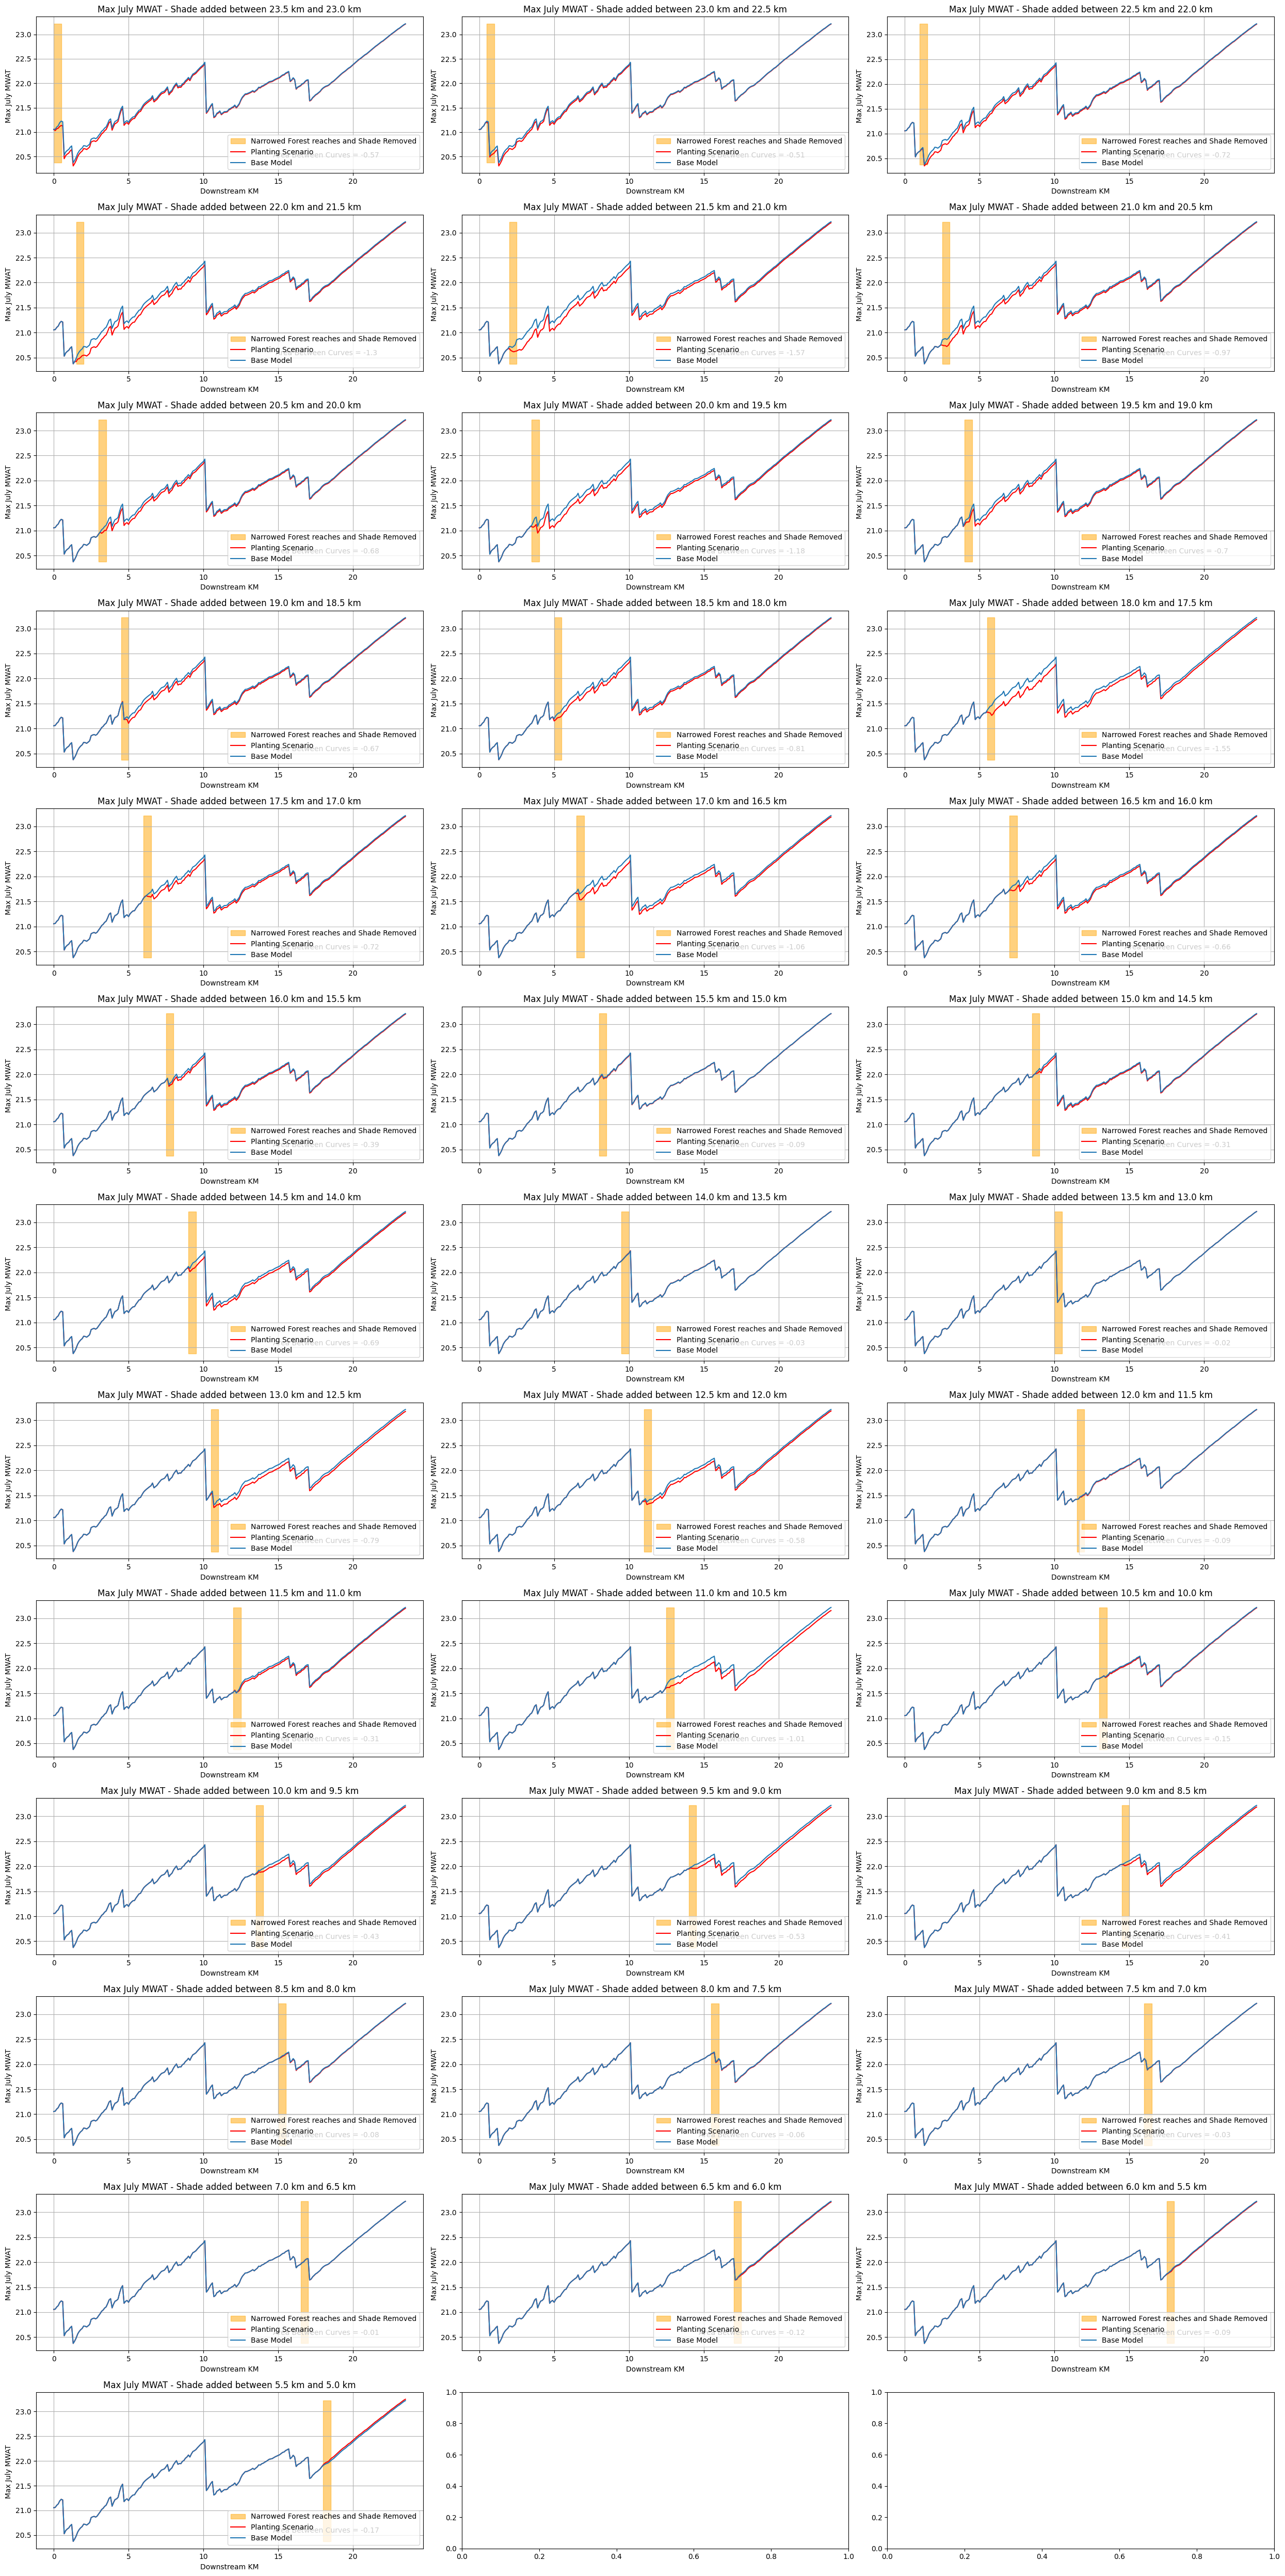

In [12]:
obs["datetime"] = pd.to_datetime(obs["datetime"])
#obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'08-01-2023')]# + pd.DateOffset(1))]
obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end + pd.DateOffset(1))]


obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
#obs_clip.drop(19.2, axis=1, inplace=True)
#plotting from bankbuffer
fig, axes = plt.subplots(13, 3, figsize=(25, 50))

    # Flatten the axes array to make it easier to iterate over
axes = axes.flatten()
hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='H', inclusive='left') 
daily_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left') 
#upstreamconstant_df = 
upstreamconstant_df = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 237))
upstreamconstant_df.columns = [float(col) for col in upstreamconstant_df.columns]
upstreamconstant_df.index = obs_clip.index
# mean july temperature summary
#upstreamconstant_modeled_mean = upstreamconstant_df.resample('D').mean()

upstreamconstant_modeled = upstreamconstant_df.resample('D').mean()

upstreamconstant_modeled = upstreamconstant_modeled.mean()    
upstreamconstant_modeled = pd.DataFrame(upstreamconstant_modeled)
upstreamconstant_modeled = upstreamconstant_modeled.reset_index()
upstreamconstant_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)

obs_rolling_avg = upstreamconstant_modeled_mean.rolling(window=7).max()
obs_max_mwat = obs_rolling_avg.max()
upstreamconstant_modeled['Max MWAT'] = obs_max_mwat.values

#base shade scenario

base_shade_df = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Shade.csv'), skiprows=6, usecols=range(1, 237))
base_hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='H', inclusive='left')  # Closed left ensures end date is exclusive
base_shade_df.columns = [float(col) for col in base_shade_df.columns]
base_shade_df.index = daily_index
# base_shade_df.index = obs_clip.index

base_shade = base_shade_df.mean()
base_shade = pd.DataFrame(base_shade)
base_shade = base_shade.reset_index()
base_shade.rename(columns={'index': 'NODE_ID', 0 : 'Effective Shade %'}, inplace=True)

#discts to hold differneces between scenarios
effectiveness_difference = {}
reach_shade_base = {}
reach_shade_scenario = {}
reach_shade_change = {}
reach_velocity = {}
reach_width = {}
reach_depth = {}
reach_widthdepth = {}
reach_azimuth = {}
reach_gradient = {}
count = 0
for i in values:
    count += 1
    km_start = i
    km_end = i-.5
    if km_start == 0:
        continue
    else:
        # km_start = i+1
        # km_end = i
        reach_source_folder = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_outputs', 'sensitivity_analysis', 'july_treeplantingWiden40', f'treeplanting_widen40_{i}'))
        modeled_tw_df = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 237))
        modeled_tw_df.columns = [float(col) for col in modeled_tw_df.columns]
        modeled_tw_df.index = obs_clip.index
        # mean july temperature summary
        mean_daily_modeled = modeled_tw_df.resample('D').mean()
        mean_july_modeled = mean_daily_modeled.mean()    
        mean_july_modeled = pd.DataFrame(mean_july_modeled)
        mean_july_modeled = mean_july_modeled.reset_index()
        mean_july_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)
        sim__rolling_avg = mean_daily_modeled.rolling(window=7).max()
        sim_max_mwat = sim__rolling_avg.max()
        mean_july_modeled['Max MWAT'] = sim_max_mwat.values
        # mwat = mean_daily_modeled.rolling(window=7).max()
        # mwat = mwat.max()
        # mwat = pd.DataFrame(mwat)
        # mean_july_modeled = pd.merge(mean_july_modeled, mwat[0], left_on='NODE_ID', right_index = True, how='left')
        # mean_july_modeled.rename(columns={0: 'Max MWAT'}, inplace=True) 
        
        #saving reach effectiveness
        # difference = mean_july_modeled['Mean July Temp'] - upstreamconstant_modeled['Mean July Temp']
        # norm_difference = difference/km_start
        # norm_difference = norm_difference.values.sum()
        # norm_effectiveness_difference[km_start] = norm_difference
        # effectiveness_difference[km_start] = difference.values.sum()
        
        #doing integration
        x = mean_july_modeled['NODE_ID']
        y1 = mean_july_modeled['Mean July Temp']
        y2 = upstreamconstant_modeled['Mean July Temp']

        
        
        
        
        # Compute absolute difference between the curves
        abs_diff = np.abs(y1 - y2)

        # Use Simpson's rule for numerical integration
        area = simps(abs_diff, x)
        #changing sign of degree kilomters to be negative or positive based on if its cooling (negative) or warming (positive) from restoration
        if (upstreamconstant_modeled - mean_july_modeled ).mean()['Mean July Temp'] <= 0:
            area = area*-1
        area
    
        
        effectiveness_difference[km_start] = area
        
        #getting effective shade values
        control_file = pd.read_csv(os.path.join(base_source_folder, 'HeatSource_Control.csv'))
        cc_start = control_file.loc[7]['VALUE']
        cc_start = pd.to_datetime(cc_start)
        cc_end = control_file.loc[8]['VALUE']
        cc_end = pd.to_datetime(cc_end)
        scenario_shade_df = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Shade.csv'), skiprows=6, usecols=range(1, 237))
        # hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left')  # Closed left ensures end date is exclusive
        #         hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left')  # Closed left ensures end date is exclusive

        scenario_shade_df.columns = [float(col) for col in scenario_shade_df.columns]
        scenario_shade_df.index = daily_index
        shade = scenario_shade_df.mean()
        shade = pd.DataFrame(shade)
        shade = shade.reset_index()
        shade.rename(columns={'index': 'NODE_ID', 0 : 'Effective Shade %'}, inplace=True)
        reach = shade[(shade['NODE_ID'] <= km_start) & (shade['NODE_ID'] >=km_end)]
        base_reach = base_shade[(base_shade['NODE_ID'] <= km_start) & (base_shade['NODE_ID'] >=km_end)]
        #compare base shade to scenario shade
        reach_percent_increase = (base_reach - reach)/base_reach
        reach_difference = reach - base_reach

        reach_mean_percent_increase = reach_percent_increase['Effective Shade %'].mean()    
        #reach_shade[km_start] = reach_mean_percent_increase
        reach_shade_base[km_start] = base_reach['Effective Shade %'].mean()
        reach_shade_scenario[km_start] = reach['Effective Shade %'].mean()
        reach_shade_change[km_start] = reach_difference['Effective Shade %'].mean()

         #get reach azimuth
        azimuth = pd.read_csv(os.path.abspath(os.path.join(script_dir, 'scenarios','stream_azimuth.csv')))
        azimuth_reach = azimuth[(azimuth['STREAM_KM'] <= km_start) & (azimuth['STREAM_KM'] >=km_end)]
        azimuth_reach_mean = azimuth_reach['Azm'].mean()
        reach_azimuth[km_start] = abs(azimuth_reach_mean-180)
        
        #get reach gradient 
        gradient = pd.read_csv(os.path.abspath(os.path.join(script_dir, 'scenarios','stream_azimuth.csv')))
        gradient_reach = gradient[(gradient['STREAM_KM'] <= km_start) & (gradient['STREAM_KM'] >=km_end)]
        gradient_reach_mean = gradient_reach['GRADIENT'].mean()
        reach_gradient[km_start] = gradient_reach_mean

        #getting mean velocity
        velocity = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_Vel.csv'), skiprows=6, usecols=range(1, 237))
        velocity.columns = [float(col) for col in velocity.columns]
        sim_velocity = velocity.mean()#.to_numpy()
        sim_velocity = pd.DataFrame(sim_velocity)
        sim_velocity = sim_velocity.reset_index()
        sim_velocity.rename(columns={'index': 'NODE_ID', 0 : 'Velocity'}, inplace=True)
        velocity_reach = sim_velocity[(sim_velocity['NODE_ID'] <= km_start) & (sim_velocity['NODE_ID'] >=km_end)]
        reach_mean_velocity = velocity_reach['Velocity'].mean()
        reach_velocity[km_start] = reach_mean_velocity
        
        #Getting Width
        sim_width = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_WT.csv'), skiprows=6, usecols=range(1, 237))
        sim_width.columns = [float(col) for col in sim_width.columns]
        sim_width = sim_width.iloc[0]#.to_numpy()
        sim_width = pd.DataFrame(sim_width)
        sim_width = sim_width.reset_index()
        sim_width.rename(columns={'index': 'NODE_ID', 0 : 'Width'}, inplace=True)
        sim_width = sim_width[(sim_width['NODE_ID'] <= km_start) & (sim_width['NODE_ID'] >=km_end)]
        reach_width[km_start] = sim_width['Width'].mean()
        
        #getting depth
        sim_depth = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_DA.csv'), skiprows=6, usecols=range(1, 237))
        sim_depth.columns = [float(col) for col in sim_depth.columns]
        sim_depth = sim_depth.iloc[0]#.to_numpy()
        sim_depth = pd.DataFrame(sim_depth)
        sim_depth = sim_depth.reset_index()
        sim_depth.rename(columns={'index': 'NODE_ID', 0 : f'Depth'}, inplace=True)
        sim_depth = sim_depth[(sim_depth['NODE_ID'] <= km_start) & (sim_depth['NODE_ID'] >=km_end)]
        reach_depth[km_start] = sim_depth['Depth'].mean()
        #width:depth
        reach_widthdepth[km_start] = (sim_width['Width'].mean()/sim_depth['Depth'].mean())
        #plotting
        # Create a new figure with a 3x3 grid of subplots

        shade_start = i
        #plt.figure()  # Create a new figure for each iteration  
        axes[count-1].fill_between([23.5 - km_start, 23.5 - km_end], upstreamconstant_modeled['Mean July Temp'].min(),upstreamconstant_modeled['Mean July Temp'].max(), color='orange', alpha = .5, label = 'Narrowed Forest reaches and Shade Removed')
        axes[count-1].plot(23.5-mean_july_modeled['NODE_ID'], mean_july_modeled['Mean July Temp'], label=f'Planting Scenario', color = 'red')
        axes[count-1].plot(23.5-upstreamconstant_modeled['NODE_ID'], upstreamconstant_modeled['Mean July Temp'], label='Base Model')
        #axes[count-1].set_title(f'Max July MWAT - Shade added between {23.5 - km_start} km and {23.5 - km_end} km')
        axes[count-1].set_title(f'Max July MWAT - Shade added between {km_start} km and {km_end} km')

        axes[count-1].set_xlabel('Downstream KM')  # Replace 'X Label' with appropriate label
        axes[count-1].set_ylabel('Max July MWAT ')  # Replace 'Y Label' with appropriate label
        axes[count-1].text(0.75, 0.1, f'Area Between Curves = {round(area,2)}', horizontalalignment='center', transform=axes[count-1].transAxes)

        # Plot the shade data on the second y-axis
        # axes[count-1] = axes[count-1].twinx()
        # axes[count-1].plot(23.5-shade.index, shade[0], label='Mean Solar Radiation Flux \n At Stream Surface', color='red', alpha = .5)
        # axes[count-1].set_ylabel('Mean Solar Radiation Flux \n At Stream Surface (W/m2)', color = 'red')
        # axes[count-1].tick_params(axis='y', colors='red')

        axes[count-1].vlines([23.5 - km_start, 23.5 - km_end], ymin = upstreamconstant_modeled['Max MWAT'].min(), ymax = upstreamconstant_modeled['Max MWAT'].max(),color = 'orange', linestyles = 'dashed')
        axes[count-1].grid(True) 
        axes[count-1].legend(loc = 'lower right')

        #axes[count-1].legend(loc = 'lower right')
        # axes[count-1].set_xlim([18.3 - km_end-2, 18.3 - km_start+2 ])


    #plt.show()
    #add vertical line where shade is added              
plt.tight_layout()
fig.patch.set_facecolor('white')

#plt.savefig(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/500m_run/narrow/reach_shaderemoval+narrow20.png')
plt.show()
#new_folder_name = f"folder_{km_start}"

In [ ]:
reach_gradient_dict

,Reach Start KM,Gradient
0,23.5,0.007750
1,23.0,0.002177
2,22.5,0.000885
3,22.0,0.001781
4,21.5,0.006414
5,21.0,0.004451
6,20.5,0.002305
7,20.0,0.002934
8,19.5,0.004800
9,19.0,0.001670


In [ ]:
nodes = gpd.read_file(os.path.abspath(os.path.join(script_dir, 'shp', 'centerline_500msplit.shp')))
nodes

,Id,ORIG_FID,ORIG_SEQ,Shape_Leng,ReachStart,reach,geometry
0,0,0,4,500.000119,3,34.0,"LINESTRING (539112.629 173034.274, 539112.344 ..."
1,0,0,3,499.999985,2,35.0,"LINESTRING (539310.692 172939.213, 539310.782 ..."
2,0,0,2,499.999924,1,36.0,"LINESTRING (539618.146 172853.411, 539619.287 ..."
3,0,0,5,500.000039,4,33.0,"LINESTRING (538863.403 173202.513, 538862.798 ..."
4,0,0,6,500.000046,5,32.0,"LINESTRING (538494.291 173497.901, 538491.983 ..."
5,0,0,7,499.999965,6,31.0,"LINESTRING (538412.909 173913.533, 538411.550 ..."
6,0,0,8,499.999909,7,30.0,"LINESTRING (538423.841 174268.490, 538423.218 ..."
7,0,0,9,500.000054,8,29.0,"LINESTRING (538182.590 174549.801, 538180.330 ..."
8,0,0,10,500.000022,9,28.0,"LINESTRING (538185.259 174961.255, 538187.209 ..."
9,0,0,12,500.000040,11,26.0,"LINESTRING (537823.444 175371.598, 537816.051 ..."


In [ ]:
#shapefile with spatial info for 500m restoration reaches
nodes = gpd.read_file(os.path.abspath(os.path.join(script_dir, 'shp', 'centerline_500msplit.shp')))

#making dataframes from info about each restoration reach
reach_shadescenario_dict = pd.DataFrame(list(reach_shade_scenario.items()), columns=['Reach Start KM', 'SR Scenario'])
reach_shadebase_dict = pd.DataFrame(list(reach_shade_base.items()), columns=['Reach Start KM', 'SR Baseline'])
reach_velocity_dict = pd.DataFrame(list(reach_velocity.items()), columns=['Reach Start KM', 'Velocity'])
reach_width_dict = pd.DataFrame(list(reach_width.items()), columns=['Reach Start KM', 'Width'])
reach_depth_dict = pd.DataFrame(list(reach_depth.items()), columns=['Reach Start KM', 'Depth'])
reach_widthdepth_dict = pd.DataFrame(list(reach_widthdepth.items()), columns=['Reach Start KM', 'Width:Depth'])
reach_shadedif_dict = pd.DataFrame(list(reach_shade_change.items()), columns=['Reach Start KM', 'SR Difference'])
reach_azimuth_dict = pd.DataFrame(list(reach_azimuth.items()), columns=['Reach Start KM', 'Mean Azimuth'])
reach_gradient_dict = pd.DataFrame(list(reach_gradient.items()), columns=['Reach Start KM', 'Gradient'])



#creating df to add to 
dif_df_dict = pd.DataFrame(list(effectiveness_difference.items()), columns=['Reach Start KM', 'Degree Kilometers'])

#adding data from scenarios
dif_df_dict['Model Start KM'] = dif_df_dict['Reach Start KM']
dif_df_dict['Reach Start KM'] = dif_df_dict['Reach Start KM']-5
dif_df_dict['Mean velocity'] = reach_velocity_dict['Velocity']
dif_df_dict['Mean Azimuth'] = reach_azimuth_dict['Mean Azimuth']
dif_df_dict['Width'] = reach_width_dict['Width']
dif_df_dict['Depth'] = reach_depth_dict['Depth']
dif_df_dict['Width:Depth'] = reach_widthdepth_dict['Width:Depth']
dif_df_dict['Change in SR'] = reach_shadedif_dict['SR Difference']*100
dif_df_dict['Baseline SR'] = reach_shadebase_dict['SR Baseline'] *100
dif_df_dict['Scenario SR'] = reach_shadescenario_dict['SR Scenario']*100
dif_df_dict['absolute DK'] = abs(dif_df_dict['Degree Kilometers'])
dif_df_dict['Gradient'] = reach_gradient_dict['Gradient']

dif_df_dict['reach2'] = dif_df_dict.index


#dif_df_dict.drop(dif_df_dict.tail(1).index, inplace=True)
dif_df_dict['Distance Downstream'] = 18.5 - dif_df_dict['Reach Start KM']
dif_df_dict = dif_df_dict.sort_values('Degree Kilometers')
dif_df_dict.reset_index(drop=True, inplace=True)
dif_df_dict.index.name = 'Effectiveness Rank'
dif_df_dict.reset_index(inplace=True)
#dif_df_dict.index += 1
merged_gdf_dif = pd.merge(nodes, dif_df_dict[['Reach Start KM','Degree Kilometers', 'reach2','absolute DK','Effectiveness Rank', 'Width', 'Baseline SR', 'Change in SR', 'Mean velocity']], left_on='reach2', right_on = 'reach2', how='left')
#merged_gdf_dif.drop(merged_gdf_dif['row'], axis=0, errors='ignore')

#merged_gdf_dif.to_file(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/extending_model/ranking_treeremoval.shp')
#dif_df_dict.sort_values(by = 'Effectiveness Rank')
#$merged_gdf_dif
merged_gdf_dif

,Id,ORIG_FID,ORIG_SEQ,Shape_Leng,reach2,geometry,Reach Start KM,Degree Kilometers,absolute DK,Effectiveness Rank,Width,Baseline SR,Change in SR,Mean velocity
0,0,0,4,500.000119,34,"LINESTRING (539112.629 173034.274, 539112.344 ...",1.5,-0.168426,0.168426,30,16.551667,4.779000,17.991000,0.151487
1,0,0,3,499.999985,35,"LINESTRING (539310.692 172939.213, 539310.782 ...",1.0,-0.171370,0.171370,29,15.252383,4.229667,18.529333,0.297287
2,0,0,2,499.999924,36,"LINESTRING (539618.146 172853.411, 539619.287 ...",0.5,-0.061475,0.061475,36,11.843300,4.674000,4.932000,0.468540
3,0,0,5,500.000039,33,"LINESTRING (538863.403 173202.513, 538862.798 ...",2.0,-0.108999,0.108999,34,15.943750,4.731667,14.666000,0.264079
4,0,0,6,500.000046,32,"LINESTRING (538494.291 173497.901, 538491.983 ...",2.5,-0.122608,0.122608,33,18.937000,4.611667,16.030333,0.444929
5,0,0,7,499.999965,31,"LINESTRING (538412.909 173913.533, 538411.550 ...",3.0,-0.132273,0.132273,32,14.544617,5.803667,17.174000,0.349940
6,0,0,8,499.999909,30,"LINESTRING (538423.841 174268.490, 538423.218 ...",3.5,-0.185769,0.185769,28,12.545183,6.204333,17.160667,0.204170
7,0,0,9,500.000054,29,"LINESTRING (538182.590 174549.801, 538180.330 ...",4.0,-0.478705,0.478705,22,12.549850,13.093333,27.860000,0.243764
8,0,0,10,500.000022,28,"LINESTRING (538185.259 174961.255, 538187.209 ...",4.5,-0.601304,0.601304,17,12.138433,10.638667,32.946333,0.195542
9,0,0,12,500.000040,26,"LINESTRING (537823.444 175371.598, 537816.051 ...",5.5,-0.290646,0.290646,25,14.785617,7.956667,18.046333,0.197561


In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx
import scienceplots


# Define the original colormap
original_cmap = plt.cm.copper
degree_cmap = plt.cm.RdBu
inverted_degree_cmap = degree_cmap.reversed()

# Invert the colormap
inverted_cmap = original_cmap.reversed()

# Define the boundaries for the colorbar steps
bounds_width = [merged_gdf_dif['Width'].min(), merged_gdf_dif['Width'].max()]  
bounds_dif = [merged_gdf_dif['Baseline SR'].min(), merged_gdf_dif['Baseline SR'].max()]
bounds_changeSR = [merged_gdf_dif['Change in SR'].min(), merged_gdf_dif['Change in SR'].max()]

# Create a colormap norm with the defined boundaries
norm1 = mcolors.Normalize(vmin=merged_gdf_dif['Width'].min(), vmax=merged_gdf_dif['Width'].max())
norm2 = mcolors.Normalize(vmin=merged_gdf_dif['Baseline SR'].min(), vmax=merged_gdf_dif['Baseline SR'].max())
norm3 = mcolors.Normalize(vmin=merged_gdf_dif['Change in SR'].min(), vmax=merged_gdf_dif['Change in SR'].max())
norm4 = mcolors.Normalize(vmin=merged_gdf_dif['Degree Kilometers'].min(), vmax=merged_gdf_dif['Degree Kilometers'].max())

with plt.style.context(['science', 'no-latex']):
    # plotting the difference in temps between modeled reaches, with ranking
    fig, axes = plt.subplots(2, 2, figsize=(40, 20), layout = 'compressed')
    fig.suptitle('Non-Forested Baseline \nTree Planting', fontsize=30)

    db_lonlat = merged_gdf_dif.to_crs(epsg=4326)
    #ctx.add_basemap(axes[0], crs=db_lonlat.crs)
    
    # Plot the first map
    ax1 = axes.flat[0]

    #ax1 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Width', cmap=inverted_cmap, linewidth=5, ax=axes[0], norm=norm1)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Width', cmap=inverted_cmap, linewidth=7, ax=ax1, norm=norm1)

    ctx.add_basemap(ax1, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax1.set_xlabel('Longitude', fontsize = 20)
    ax1.set_ylabel('Latitude', fontsize=20)
    ax1.set_title('Channel Width', fontsize=25)
    ax1.tick_params(axis='both', which='major', labelsize=17)

    # Plot the second map
    ax2 = axes.flat[1]

    # ax2 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Baseline SR', cmap=inverted_cmap, linewidth=5, ax=axes[1], norm=norm2)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Baseline SR', cmap=inverted_cmap, linewidth=7, ax=ax2, norm=norm2)

    ctx.add_basemap(ax2, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax2.set_title('Baseline Shade', fontsize=25)
    ax2.set_xlabel('Longitude', fontsize=20)
    ax2.set_ylabel('Latitude', fontsize=20)
    ax2.tick_params(axis='both', which='major', labelsize=17)

    
    ax3 = axes.flat[2]

    # ax3 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Change in SR', cmap=inverted_cmap, linewidth=5, ax=axes[2], norm=norm3)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Change in SR', cmap=inverted_cmap, linewidth=7, ax=ax3, norm=norm3)

    ctx.add_basemap(ax3, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax3.set_title('Change in Shade', fontsize=25)
    ax3.set_xlabel('Longitude', fontsize=20)
    ax3.set_ylabel('Latitude', fontsize=20)
    ax3.tick_params(axis='both', which='major', labelsize=17)

    ax4 = axes.flat[3]

    # ax4 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Degree Kilometers', cmap=inverted_degree_cmap, linewidth=5, ax=axes[3], norm=norm4)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Degree Kilometers', cmap=inverted_degree_cmap, linewidth=7, ax=ax4, norm=norm4)

    ctx.add_basemap(ax4, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax4.set_title('Thermal Restoration Index', fontsize=25)
    ax4.set_xlabel('Longitude', fontsize=20)
    ax4.set_ylabel('Latitude', fontsize=20)
    ax4.tick_params(axis='both', which='major', labelsize=17)

    # Add colorbars for clarity
    # cbar1 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm1, cmap=inverted_cmap), ax=axes[0], orientation='vertical')
    cbar1 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm1, cmap=inverted_cmap), ax=ax1, orientation='vertical')
    cbar1.set_label('Channel Width (m)', fontsize=20)
    cbar1.ax.tick_params(axis='both', which='major', labelsize=17)


    cbar2 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm2, cmap=inverted_cmap), ax=ax2, orientation='vertical')
    cbar2.set_label('Baseline Shade (%)', fontsize=20)
    cbar2.ax.tick_params(axis='both', which='major', labelsize=17)

    cbar3 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm3, cmap=inverted_cmap), ax=ax3, orientation='vertical')
    cbar3.set_label('Change in Shade (%)', fontsize=20)
    cbar3.ax.tick_params(axis='both', which='major', labelsize=17)

    cbar4 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm4, cmap=inverted_degree_cmap), ax=ax4, orientation='vertical')
    cbar4.set_label('Thermal Restoration Index  (${^\circ}C$-km)', fontsize=20)
    cbar4.ax.tick_params(axis='both', which='major', labelsize=17)
    cbar4.set_ticks([merged_gdf_dif['Degree Kilometers'].min(), 0, merged_gdf_dif['Degree Kilometers'].max()])
    cbar4.ax.set_yticklabels([f'{merged_gdf_dif["Degree Kilometers"].min():.2f}', '0', f'{merged_gdf_dif["Degree Kilometers"].max():.2f}'])


    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\500mTreePlantingEffectiveness.png', bbox_inches='tight', dpi=300)
    plt.show()


NameError: name 'merged_gdf_dif' is not defined

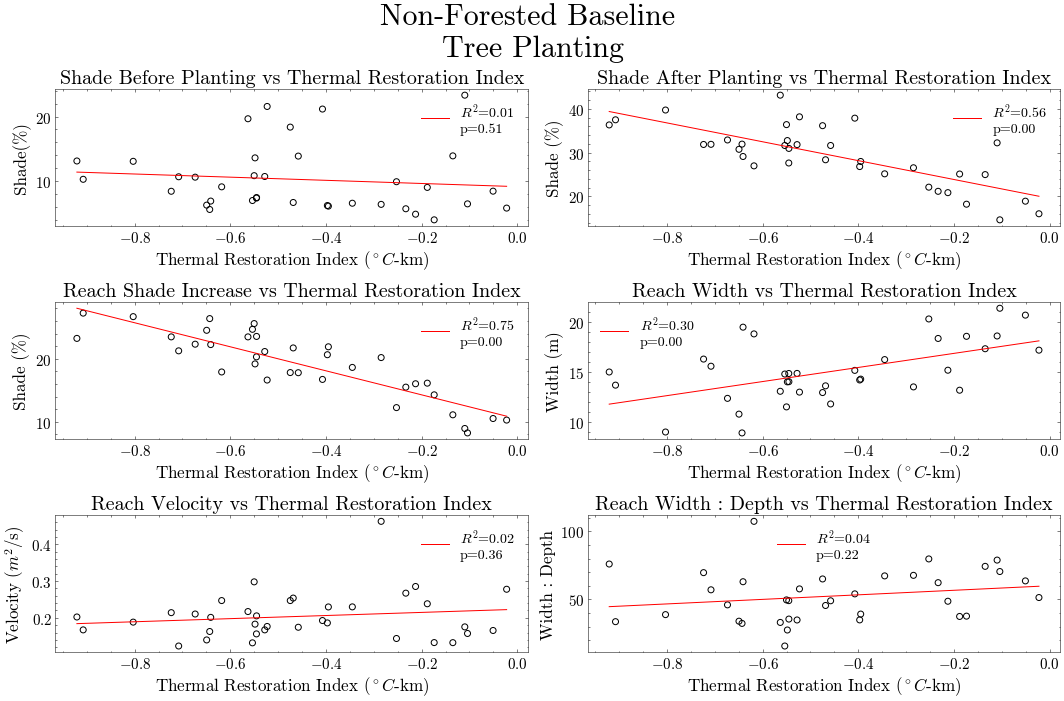

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

# Assuming dif_df_dict contains your data

# Define a function for plotting
def plot_scatter_and_regression(x_data, y_data, x_label, y_title, y_label, ax):
    with plt.style.context(['science', 'no-latex']):
        #x_data = x_data*-1
        # Fitting linear regression
        model = LinearRegression()
        model.fit(x_data, y_data)
        r_squared = model.score(x_data, y_data)

        # Calculate p-value
        slope, intercept, r_value, p_value, std_err = linregress(x_data.ravel(), y_data)

        # Scatter plot
        ax.scatter(x_data, y_data, facecolors='none', edgecolors='black')

        # Plotting the regression line
        ax.plot(x_data, model.predict(x_data), color='red', linestyle = '-',label=f'$R^2$={r_squared:.2f} \np={p_value:.2f}')
        ax.set_title(y_title+ ' vs Thermal Restoration Index', fontsize = 20)
        # Labels and legend
        ax.set_xlabel(x_label, fontsize = 17)
        ax.set_ylabel(y_label, fontsize = 17)
        ax.tick_params(axis='both', which='major', labelsize=15)

        ax.legend(fontsize = 14)
with plt.style.context(['science', 'no-latex']):
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    fig.suptitle('Non-Forested Baseline \nTree Planting', fontsize=30)

    # Plot 1
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Baseline SR'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Shade Before Planting',  'Shade(%)', axs[0, 0])

    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Scenario SR'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Shade After Planting', 'Shade (%)', axs[0, 1])

    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Change in SR'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Reach Shade Increase', 'Shade (%)', axs[1, 0])

    # Plot 2 (Assuming you have dif_df_dict2, dif_df_dict3, dif_df_dict4 for other data)
    # Adjust accordingly based on your actual data
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Width'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Reach Width', 'Width (m)', axs[1, 1])

    # Plot 3
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                dif_df_dict['Mean velocity'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Reach Velocity', 'Velocity ($m{^2}$/s)', axs[2, 0])

    # Plot 4
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Width:Depth'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Reach Width : Depth', 'Width : Depth', axs[2, 1])

    # Adjust layout
    plt.tight_layout()
    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\500mTreePlantingEffectiveness_scatter.png', bbox_inches = 'tight', dpi = 300)
    # Show plot
    plt.show()

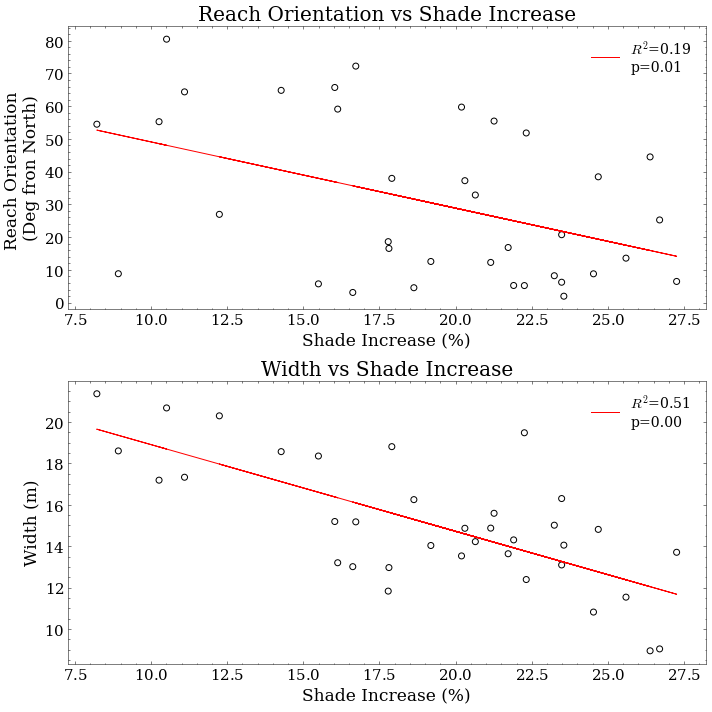

In [ ]:
# Define a function for plotting
def plot_scatter_and_regression(x_data, y_data, x_label, y_title, y_label, ax):
    with plt.style.context(['science', 'no-latex']):
        #x_data = x_data*-1
        # Fitting linear regression
        model = LinearRegression()
        model.fit(x_data, y_data)
        r_squared = model.score(x_data, y_data)

        # Calculate p-value
        slope, intercept, r_value, p_value, std_err = linregress(x_data.ravel(), y_data)

        # Scatter plot
        ax.scatter(x_data, y_data, facecolors='none', edgecolors='black')

        # Plotting the regression line
        ax.plot(x_data, model.predict(x_data), color='red', linestyle = '-',label=f'$R^2$={r_squared:.2f} \np={p_value:.2f}')
        ax.set_title(y_title + ' vs Shade Increase', fontsize = 20)
        # Labels and legend
        ax.set_xlabel(x_label, fontsize = 17)
        ax.set_ylabel(y_label, fontsize = 17)
        ax.tick_params(axis='both', which='major', labelsize=15)

        ax.legend(fontsize = 14)

with plt.style.context(['science', 'no-latex']):
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    #fig.suptitle('Influence of Width \nand Channel Orientation on Shade', fontsize=30)

    # Plot 1
    plot_scatter_and_regression(dif_df_dict['Change in SR'].values.reshape(-1, 1),
                                 dif_df_dict['Mean Azimuth'].values,
                                 'Shade Increase (%)', 'Reach Orientation', 'Reach Orientation \n(Deg fron North)', axs[0])
    #plot 2
    plot_scatter_and_regression(dif_df_dict['Change in SR'].values.reshape(-1, 1),
                                 dif_df_dict['Width'].values,
                                 'Shade Increase (%)', 'Width', 'Width (m)', axs[1])
    plt.tight_layout()
    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\Orientation_width_effectiveness.png', bbox_inches = 'tight', dpi = 300)
